In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

#=================================================
# Modify paths to point to output files
#=================================================
# Case name (Straight coast)
case_straight = 'Straight Coast'

# path to ocean_annual file
path_year_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/goodcore_300yr/21000101.ocean_annual.nc'
dy_straight = xr.open_dataset(path_year_straight, decode_times=True)

# path to ocean_month file
path_month_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/goodcore_300yr/21000101.ocean_month.nc'
dm_straight = xr.open_dataset(path_month_straight, decode_times=True)

# path to ice_month file
path_month_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/goodcore_300yr/21000101.ice_month.nc'
di_straight = xr.open_dataset(path_month_straight, decode_times=True)


# Case name (Both Coast)
case_both = 'Both Coast'

# path to ocean_annual file
path_year_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/goodcore_300yr/21000101.ocean_annual.nc'
dy_both = xr.open_dataset(path_year_both, decode_times=True)

# path to ocean_month file
path_month_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/goodcore_300yr/21000101.ocean_month.nc'
dm_both = xr.open_dataset(path_month_both, decode_times=True)

# path to ice_month file
path_month_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/goodcore_300yr/21000101.ice_month.nc'
di_both = xr.open_dataset(path_month_both, decode_times=True)


# Case name (America Coast)
case_am = 'America Coast'

# path to ocean_annual file
path_year_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/300yr/21300101.ocean_annual.nc'
dy_am = xr.open_dataset(path_year_am, decode_times=True)

# path to ocean_month file
path_month_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/300yr/21300101.ocean_month.nc'
dm_am = xr.open_dataset(path_month_am, decode_times=True)

# path to ice_month file
path_month_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/300yr/21300101.ice_month.nc'
di_am = xr.open_dataset(path_month_am, decode_times=True)


# Case name (Africa Coast)
case_af = 'Africa Coast'

# path to ocean_annual file
path_year_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/300yr/21300101.ocean_annual.nc'
dy_af = xr.open_dataset(path_year_af, decode_times=True)

# path to ocean_month file
path_month_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/300yr/21300101.ocean_month.nc'
dm_af = xr.open_dataset(path_month_af, decode_times=True)

# path to ice_month file
path_month_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/300yr/21300101.ice_month.nc'
di_af = xr.open_dataset(path_month_af, decode_times=True)


#=================================================
# Ignore runtime warnings: mean of empty slice
#=================================================
warnings.filterwarnings("ignore", message="Mean of empty slice")

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
x_west = np.where(dy_straight['xh']==211)[0][0]
x_east = np.where(dy_straight['xh']==351)[0][0]
y = np.where(dy_straight['yq']==-35)[0][0]
y_south = np.where(dy_straight['yq']==-71)[0][0]
y_north = np.where(dy_straight['yq']==71)[0][0]

In [5]:
dm_straight.T_ady_2d

<xarray.DataArray 'T_ady_2d' (time: 1200, yq: 81, xh: 180)>
[17496000 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * time     (time) object 2100-01-16 12:00:00 ... 2199-12-16 12:00:00
  * yq       (yq) float64 -79.0 -77.0 -75.0 -73.0 -71.0 ... 75.0 77.0 79.0 81.0
Attributes:
    long_name:      Vertically Integrated Advective Meridional Flux of Heat
    units:          W m-2
    cell_methods:   yq:point xh:sum time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

In [2]:
# functions
def calculate_OHT(T_ady_2d, T_diffy_2d):
    tady = np.where(np.abs(T_ady_2d) == 1e+20, np.nan, T_ady_2d)
    tady_avg = np.nanmean(tady, axis=0)
    tady_zonal = np.nansum(tady_avg, axis=1)
    tdiffy = np.where(np.abs(T_diffy_2d) == 1e+20, np.nan, T_diffy_2d)
    tdiffy_avg = np.nanmean(tdiffy, axis=0)
    tdiffy_zonal = np.nansum(tdiffy_avg, axis=1)
    OHT = (tady_zonal + tdiffy_zonal)/1e15
    return OHT

def calculate_basin_sfn(vmo, vhGM, x_west, x_east, y_south, y_north):
    vmo_slice = (np.nanmean(vmo[-31:-1,:,:,:], axis=0))
    vhGM_slice = (np.nanmean(vhGM[-31:-1,:,:,:], axis=0))
    sfn_basin_mean = (np.cumsum(np.nansum((vmo_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_res = (np.cumsum(np.nansum((vhGM_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_resmean = sfn_basin_mean + sfn_basin_res
    return sfn_basin_mean, sfn_basin_res, sfn_basin_resmean

def variablename(*arg):
    names = []
    for i in range(len(arg)):
        item = [tpl[0] for tpl in filter(lambda x: arg[i] is x[1], globals().items())]
        names.append(item)
    str(names).strip('[]')
    return names

def plot_basin_sfn(sfn_1, sfn_2, sfn_3, sfn_bound, y_south, y_north):
    lat = dy_straight['yq']; z = dy_straight['zl']
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    sfn_list = sfn_1, sfn_2, sfn_3
    names = variablename(sfn_1, sfn_2, sfn_3)
    for row in range(3):
        ax = axs[row]
        cf = ax.contourf(lat[y_south:y_north], z, sfn_list[row][:,:], b, cmap='coolwarm', extend='both')
        ax.invert_yaxis()
        ax.set_xlim(lat[y_south], lat[y_north-1])
        ax.set_title('{}'.format(str(names[row]).strip("['']")), fontsize=16)
        cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
        cbar.ax.set_ylabel('[Sv]', fontsize=12)
    axs[1].set_ylabel('Depth', fontsize=14), axs[2].set_xlabel('Latitude', fontsize=14)
#     plt.savefig(fig_path+'{}.png'.format(sname))
#     plt.show()
    return


def plot_surface_diffs(case1, case2, name1, name2):
    sst_avg = case1['tos'].mean(dim='time') - case2['tos'].mean(dim='time')
    sss_avg = case1['sos'].mean(dim='time') - case2['sos'].mean(dim='time')
    
    x_west = np.where(dy_straight['xh']==211)[0][0]
    x_east = np.where(dy_straight['xh']==351)[0][0]

    b = np.linspace(-2, 2, 21, endpoint=True)
    t = np.linspace(-2, 2, 11, endpoint=True)
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
    plt.contourf(case1['xh'], case1['yh'], sst_avg, b, 
             cmap='RdBu_r', extend='both',transform=ccrs.PlateCarree())
    cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
    cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
    plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
    plt.title('{} - {} SST'.format(name1, name2), fontsize=16)
    # plt.savefig(fig_path+'SST.png')
    plt.show()

    plt.subplots(figsize=(8,5))
    plt.plot(case1['yh'], np.nanmean(sst_avg, axis=1), linewidth=2, label='Global Mean')
    # Following two lines are for configurations with more than one basin
    plt.plot(case1['yh'], np.nanmean(sst_avg[:,x_west:x_east], axis=1), '--',linewidth=2, label='Small Basin')
    plt.plot(case1['yh'], np.nanmean(sst_avg[:,:x_west], axis=1), '--', linewidth=2, label='Large Basin')
    #
    plt.ylabel('[C]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
    plt.title('{} - {} SST'.format(name1, name2), fontsize=16)
    plt.grid()
    plt.legend()
    # plt.savefig(fig_path+'SST_section.png')
    plt.show()

    b_salt = np.linspace(-1, 1, 21, endpoint=True)
    t_salt = np.linspace(-1, 1, 11, endpoint=True)
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
    plt.contourf(case1['xh'], case1['yh'], sss_avg, b_salt, 
             cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
    cbar = plt.colorbar(ticks=t_salt, boundaries=t_salt, spacing='uniform', extend='both')
    cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
    plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
    plt.title('{} - {} SSS'.format(name1, name2), fontsize=16)
    # plt.savefig(fig_path+'SSS.png')
    plt.show()

    plt.subplots(figsize=(8,5))
    plt.plot(case1['yh'], np.nanmean(sss_avg, axis=1), linewidth=2, label='Global Mean')
    # Following two lines are for configurations with more than one basin
    plt.plot(case1['yh'], np.nanmean(sss_avg[:,x_west:x_east], axis=1), '--', linewidth=2, label='Small Basin')
    plt.plot(case1['yh'], np.nanmean(sss_avg[:,:x_west], axis=1), '--', linewidth=2, label='Large Basin')
    #
    plt.ylabel('[psu]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
    plt.title('{} - {} SSS'.format(name1, name2), fontsize=16)
    plt.grid()
    plt.legend()
    # plt.savefig(fig_path+'SSS_section.png')
    plt.show()
    return

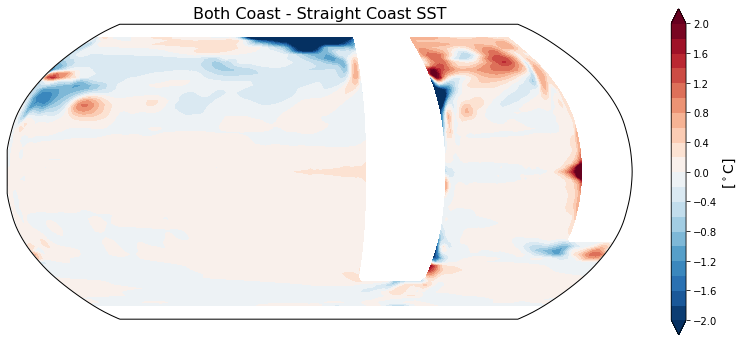

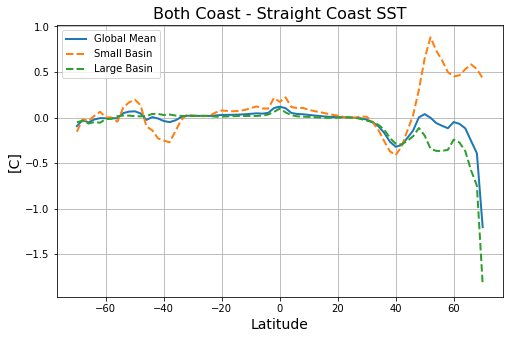

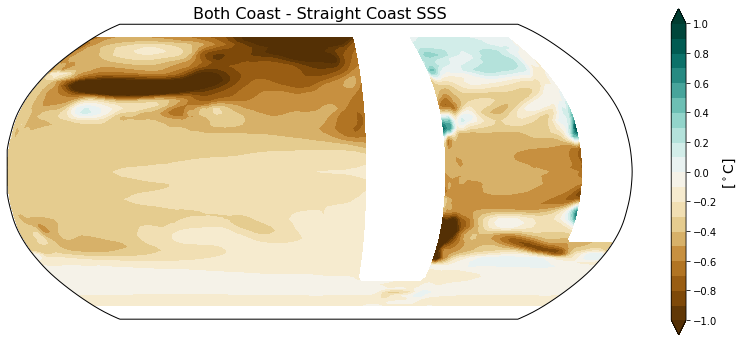

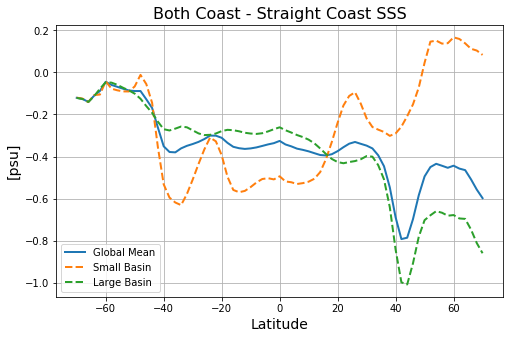

In [25]:
plot_surface_diffs(dy_both, dy_straight, case_both, case_straight)

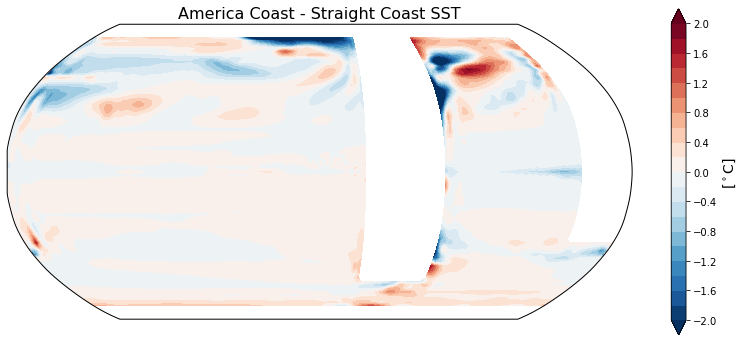

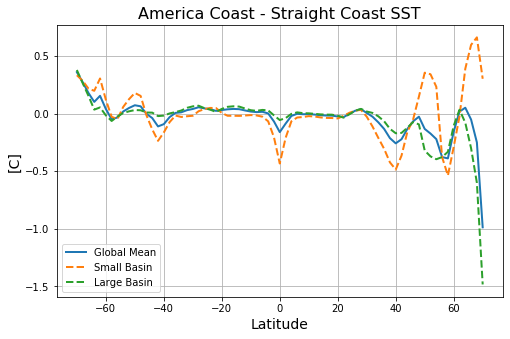

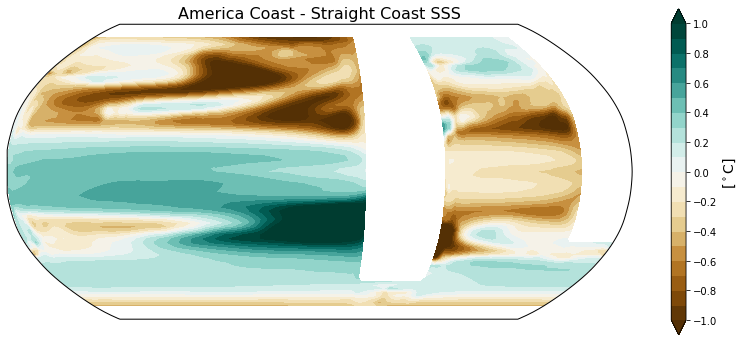

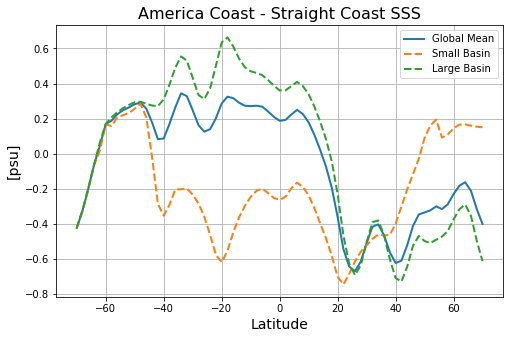

In [26]:
plot_surface_diffs(dy_am, dy_straight, case_am, case_straight)

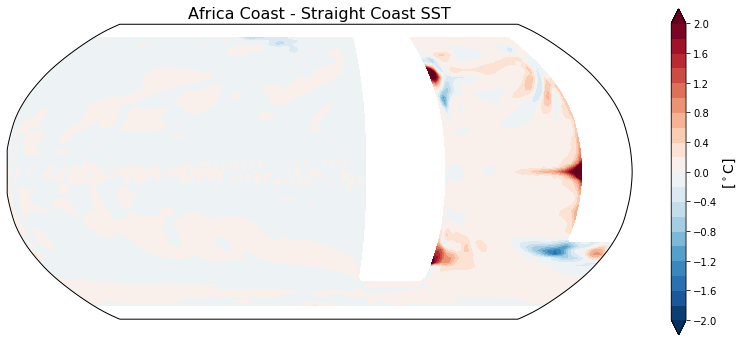

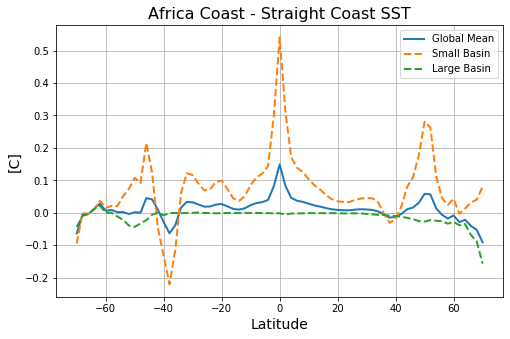

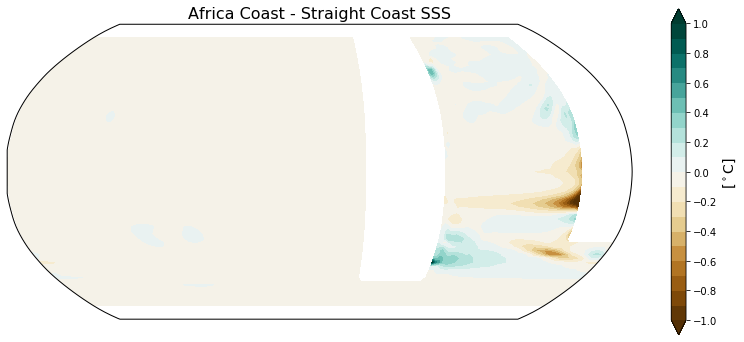

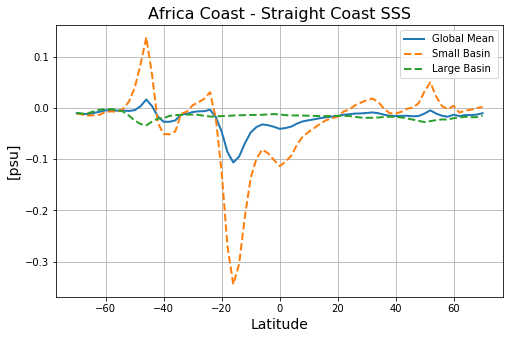

In [27]:
plot_surface_diffs(dy_af, dy_straight, case_af, case_straight)

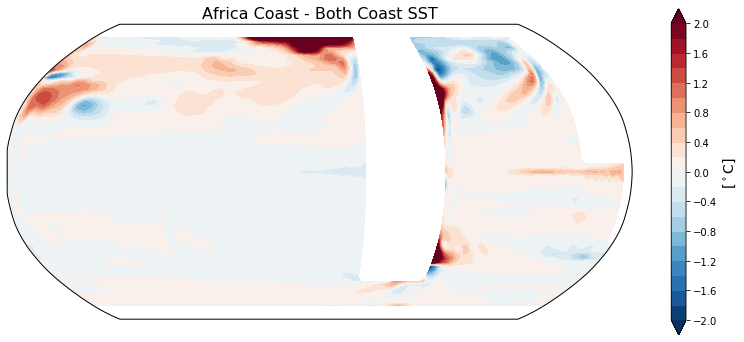

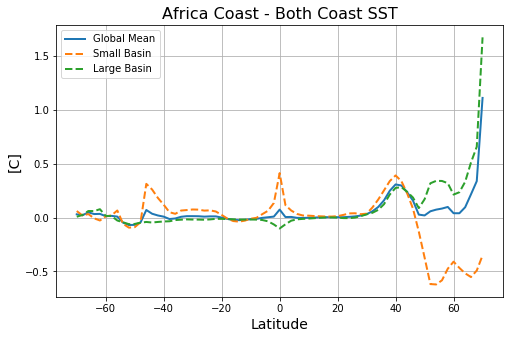

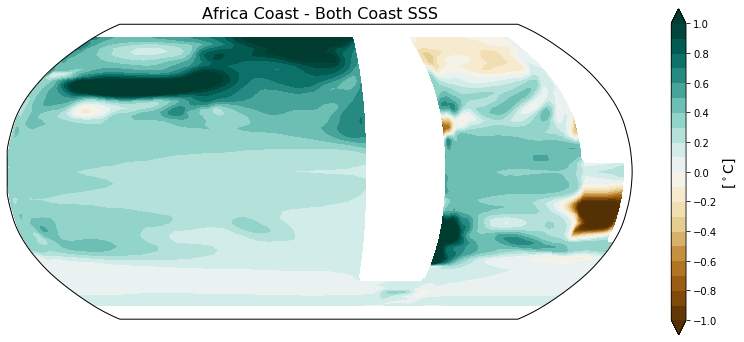

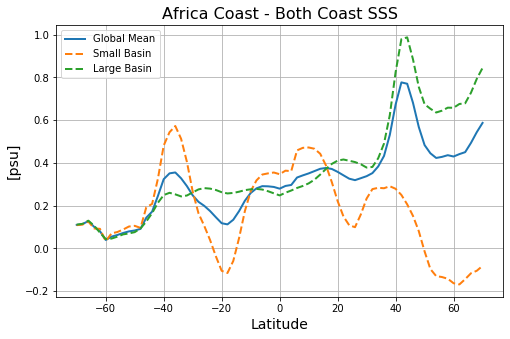

In [28]:
plot_surface_diffs(dy_af, dy_both, case_af, case_both)

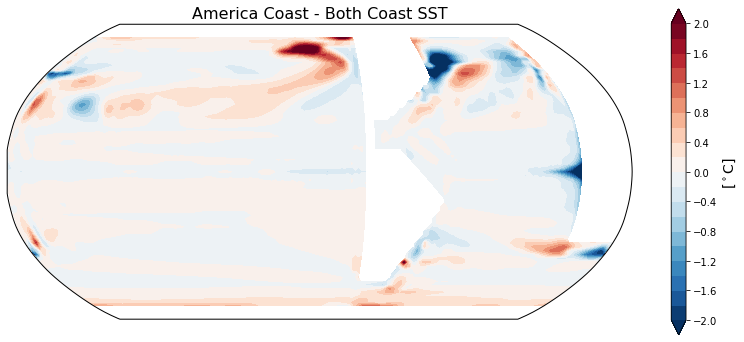

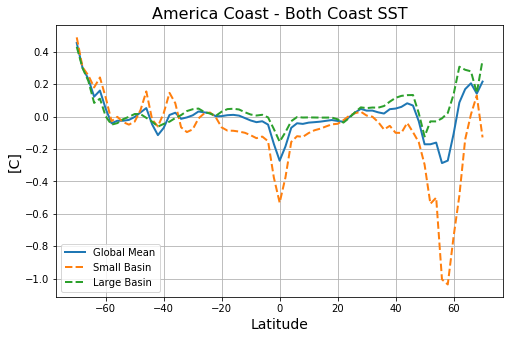

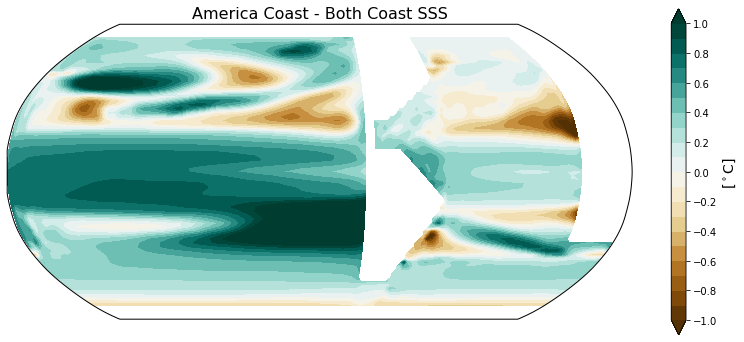

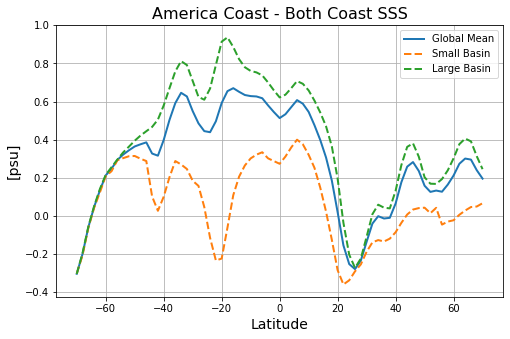

In [29]:
plot_surface_diffs(dy_am, dy_both, case_am, case_both)

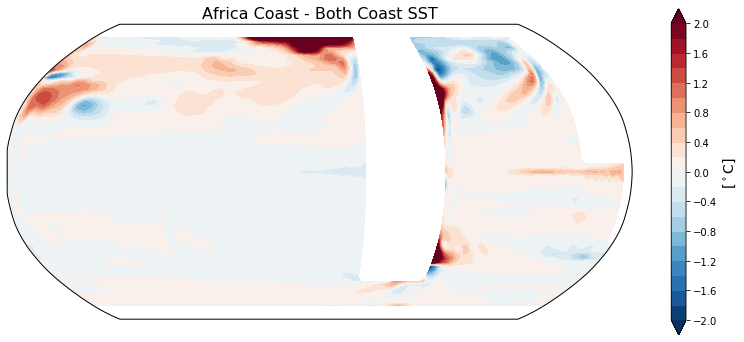

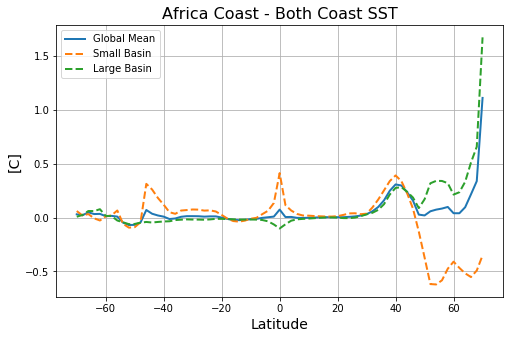

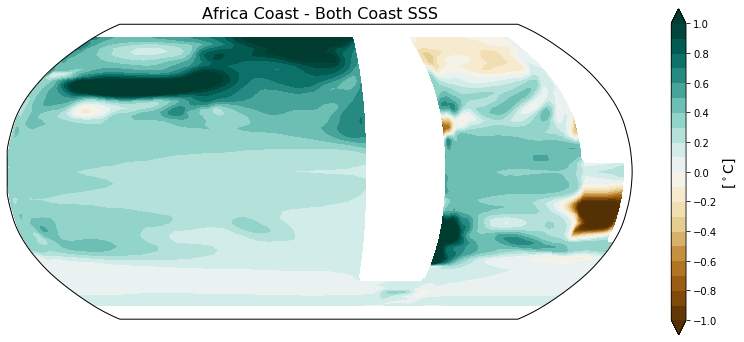

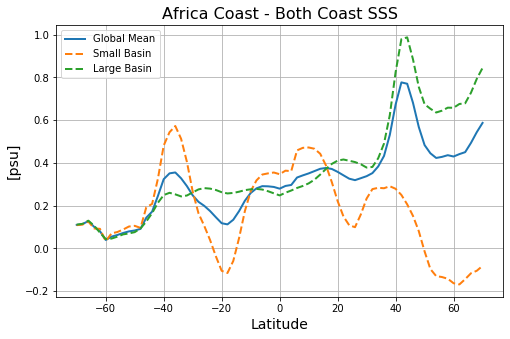

In [30]:
plot_surface_diffs(dy_af, dy_both, case_af, case_both)

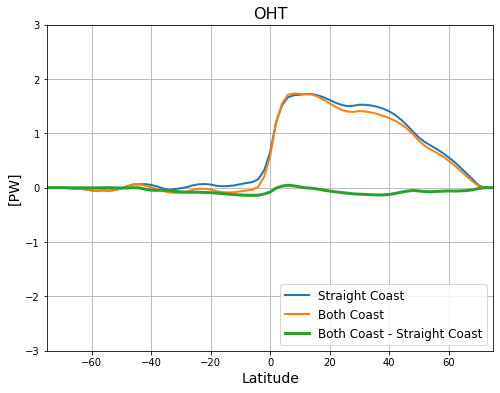

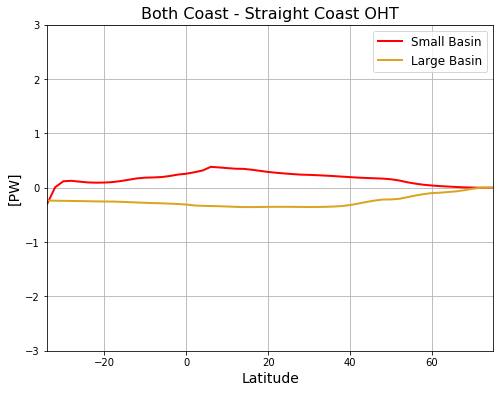

In [31]:
OHT_straight = calculate_OHT(dm_straight['T_ady_2d'], dm_straight['T_diffy_2d'])
OHT_both = calculate_OHT(dm_both['T_ady_2d'], dm_both['T_diffy_2d'])
OHT = OHT_both - OHT_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_straight, linewidth=2, label=case_straight)
ax.plot(dm_both['yq']+1, OHT_both, linewidth=2, label=case_both)
ax.plot(dm_straight['yq']+1, OHT, linewidth=3, label='{} - {}'.format(case_both, case_straight))
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_global.png')
plt.show()

OHT_small_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,x_west:x_east], 
                                   dm_straight['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,:x_west], dm_straight['T_diffy_2d'][:,:,:x_west])
OHT_small_both = calculate_OHT(dm_both['T_ady_2d'][:,:,x_west:x_east], 
                                   dm_both['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_both = calculate_OHT(dm_both['T_ady_2d'][:,:,:x_west], dm_both['T_diffy_2d'][:,:,:x_west])

OHT_small = OHT_small_both - OHT_small_straight
OHT_large = OHT_large_both - OHT_large_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm_straight['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('{} - {} OHT'.format(case_both, case_straight), fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_basins.png')
plt.show()

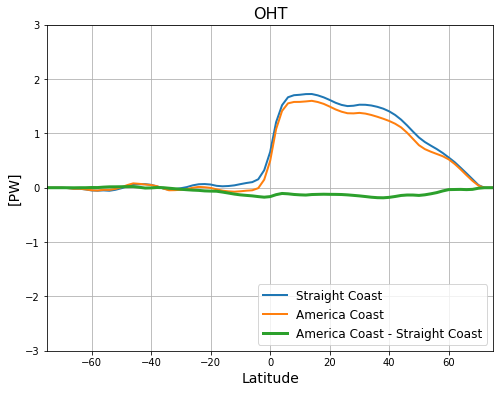

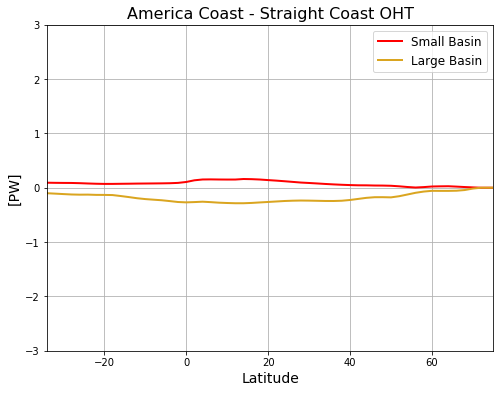

In [32]:
T_ady_2d_am = dm_am['T_ady'].sum(dim='zl')

OHT_straight = calculate_OHT(dm_straight['T_ady_2d'], dm_straight['T_diffy_2d'])
OHT_am = calculate_OHT(T_ady_2d_am, dm_am['T_diffy_2d'])
OHT = OHT_am - OHT_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_straight, linewidth=2, label=case_straight)
ax.plot(dm_am['yq']+1, OHT_am, linewidth=2, label=case_am)
ax.plot(dm_straight['yq']+1, OHT, linewidth=3, label='{} - {}'.format(case_am, case_straight))
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_global.png')
plt.show()

# OHT_small_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,x_west:x_east], 
#                                    dm_straight['T_diffy_2d'][:,:,x_west:x_east])
# OHT_large_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,:x_west], dm_straight['T_diffy_2d'][:,:,:x_west])
OHT_small_am = calculate_OHT(T_ady_2d_am[:,:,x_west:x_east], 
                                   dm_am['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_am = calculate_OHT(T_ady_2d_am[:,:,:x_west], dm_am['T_diffy_2d'][:,:,:x_west])

OHT_small = OHT_small_am - OHT_small_straight
OHT_large = OHT_large_am - OHT_large_straight 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm_straight['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('{} - {} OHT'.format(case_am, case_straight), fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_basins.png')
plt.show()


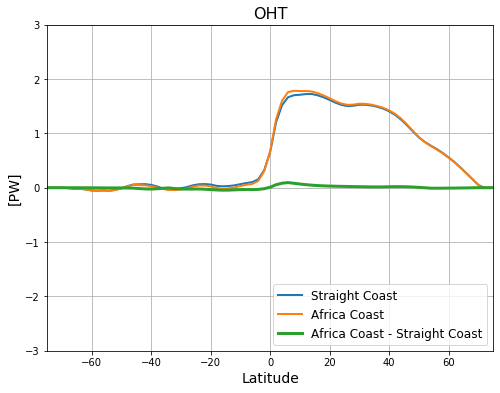

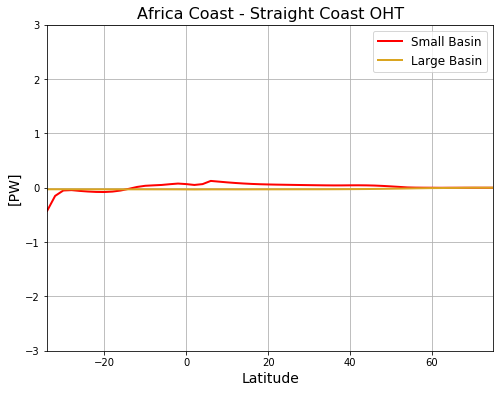

In [34]:
T_ady_2d_af = dm_af['T_ady'].sum(dim='zl')

OHT_straight = calculate_OHT(dm_straight['T_ady_2d'], dm_straight['T_diffy_2d'])
OHT_af = calculate_OHT(T_ady_2d_af, dm_af['T_diffy_2d'])
OHT = OHT_af - OHT_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_straight, linewidth=2, label=case_straight)
ax.plot(dm_af['yq']+1, OHT_af, linewidth=2, label=case_af)
ax.plot(dm_straight['yq']+1, OHT, linewidth=3, label='{} - {}'.format(case_af, case_straight))
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_global.png')
plt.show()

# OHT_small_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,x_west:x_east], 
#                                    dm_straight['T_diffy_2d'][:,:,x_west:x_east])
# OHT_large_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,:x_west], dm_straight['T_diffy_2d'][:,:,:x_west])
OHT_small_af = calculate_OHT(T_ady_2d_af[:,:,x_west:x_east], 
                                   dm_af['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_af = calculate_OHT(T_ady_2d_af[:,:,:x_west], dm_af['T_diffy_2d'][:,:,:x_west])

OHT_small = OHT_small_af - OHT_small_straight
OHT_large = OHT_large_af - OHT_large_straight 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm_straight['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('{} - {} OHT'.format(case_af, case_straight), fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_basins.png')
plt.show()

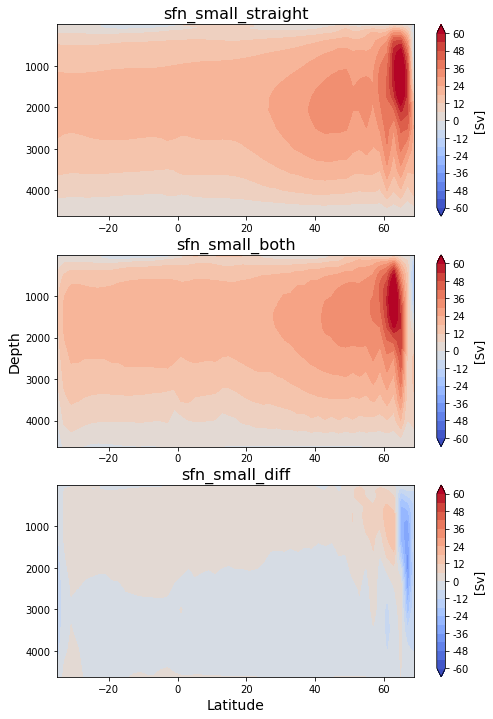

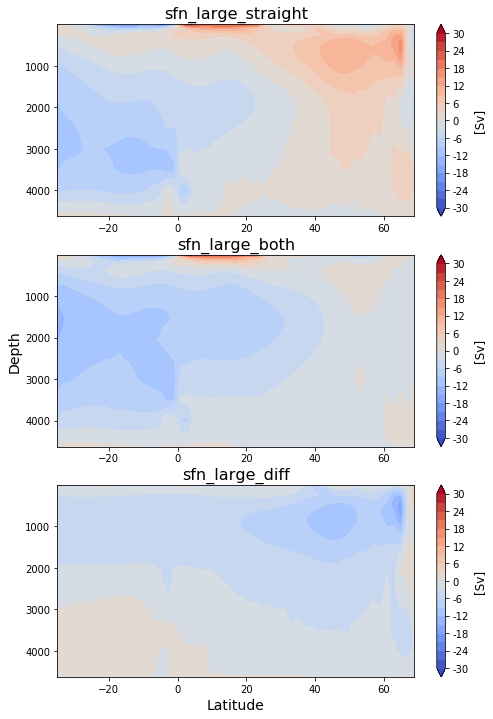

In [11]:
x, x, sfn_small_straight = calculate_basin_sfn(dy_straight['vmo'], dy_straight['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_straight = calculate_basin_sfn(dy_straight['vmo'], dy_straight['vhGM'], 0, x_west, y, y_north)

x, x, sfn_small_both = calculate_basin_sfn(dy_both['vmo'], dy_both['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_both = calculate_basin_sfn(dy_both['vmo'], dy_both['vhGM'], 0, x_west, y, y_north)

sfn_small_diff = sfn_small_both - sfn_small_straight
sfn_large_diff = sfn_large_both - sfn_large_straight

plot_basin_sfn(sfn_small_straight, sfn_small_both, sfn_small_diff, 60, y, y_north)
plot_basin_sfn(sfn_large_straight, sfn_large_both, sfn_large_diff, 30, y, y_north)

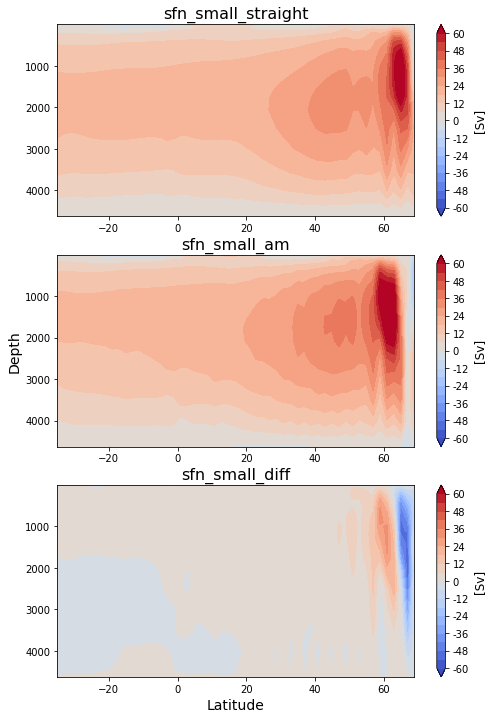

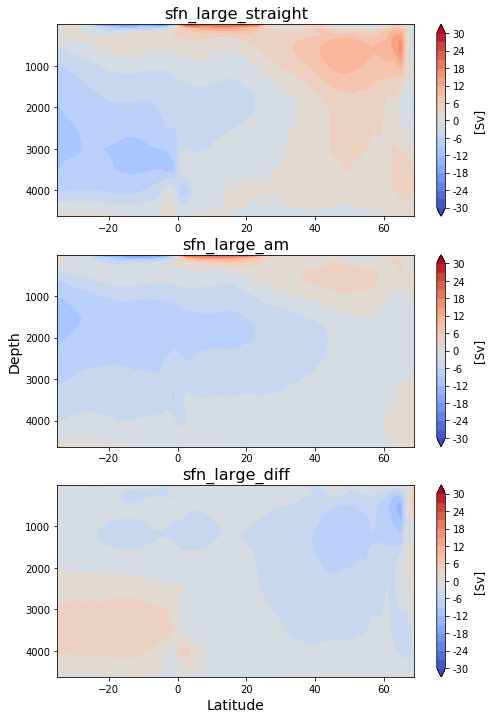

In [12]:
x, x, sfn_small_am = calculate_basin_sfn(dy_am['vmo'], dy_am['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_am = calculate_basin_sfn(dy_am['vmo'], dy_am['vhGM'], 0, x_west, y, y_north)

sfn_small_diff = sfn_small_am - sfn_small_straight
sfn_large_diff = sfn_large_am - sfn_large_straight

plot_basin_sfn(sfn_small_straight, sfn_small_am, sfn_small_diff, 60, y, y_north)
plot_basin_sfn(sfn_large_straight, sfn_large_am, sfn_large_diff, 30, y, y_north)

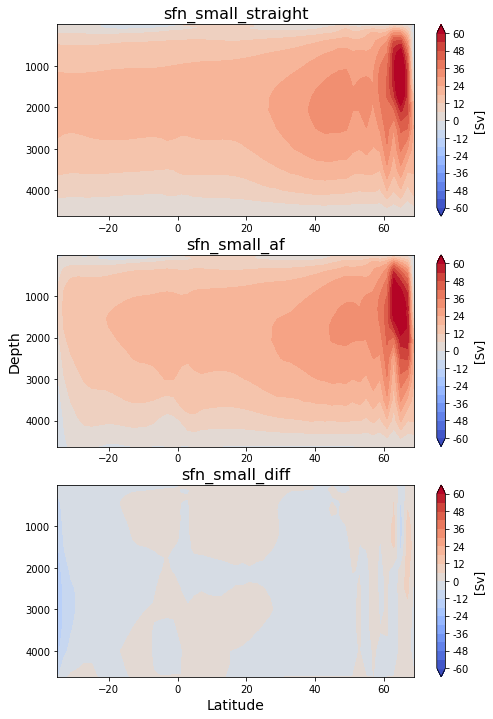

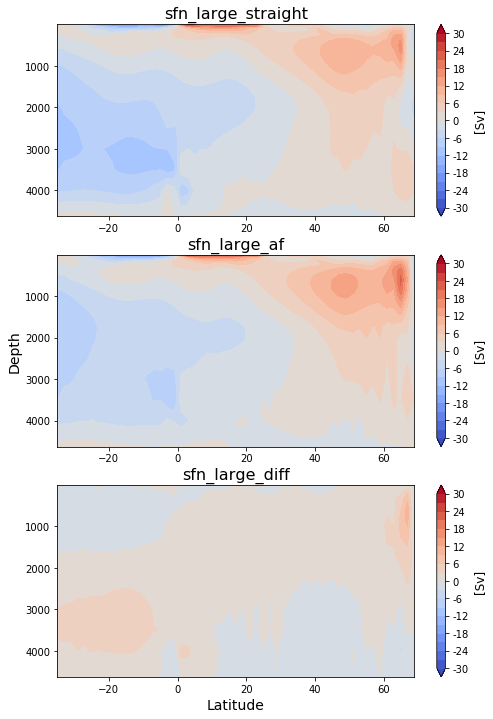

In [13]:
x, x, sfn_small_af = calculate_basin_sfn(dy_af['vmo'], dy_af['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_af = calculate_basin_sfn(dy_af['vmo'], dy_af['vhGM'], 0, x_west, y, y_north)

sfn_small_diff = sfn_small_af - sfn_small_straight
sfn_large_diff = sfn_large_af - sfn_large_straight

plot_basin_sfn(sfn_small_straight, sfn_small_af, sfn_small_diff, 60, y, y_north)
plot_basin_sfn(sfn_large_straight, sfn_large_af, sfn_large_diff, 30, y, y_north)

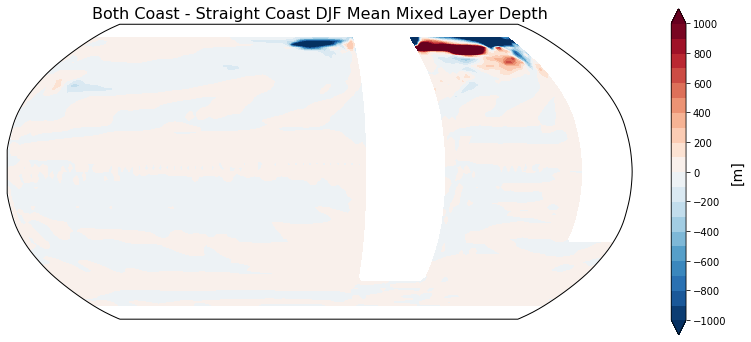

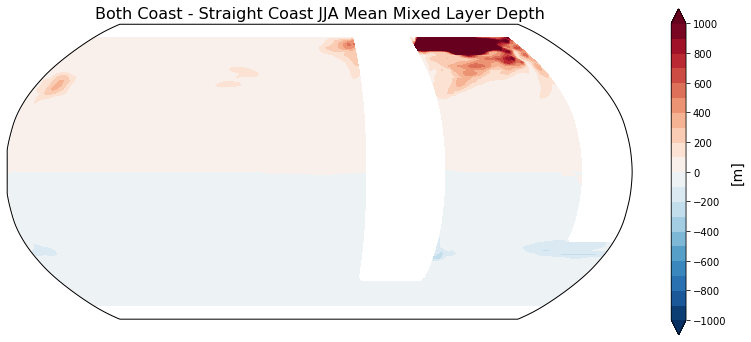

In [19]:
mld_straight = dm_straight['mlotst'][-31:,:,:]
mld_djf_straight = np.nanmean(mld_straight.where(dm_straight['time.season'] == 'DJF'), axis=0)
mld_jja_straight = np.nanmean(mld_straight.where(dm_straight['time.season'] == 'JJA'), axis=0)
mld_both = dm_both['mlotst'][-31:,:,:]
mld_djf_both = np.nanmean(mld_both.where(dm_both['time.season'] == 'DJF'), axis=0)
mld_jja_both = np.nanmean(mld_both.where(dm_both['time.season'] == 'JJA'), axis=0)

mld_djf = mld_djf_both - mld_djf_straight
mld_jja = mld_djf_both - mld_jja_straight

b = np.linspace(-1000, 1000, 21, endpoint=True)
t = np.linspace(-1000, 1000, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm_straight['xh'], dm_straight['yh'], mld_djf, b, extend='both', 
             cmap='RdBu_r', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} DJF Mean Mixed Layer Depth'.format(case_both, case_straight), fontsize=16)
# plt.savefig(fig_path+'MLD_DJF.png')
plt.show()

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm_straight['xh'], dm_straight['yh'], mld_jja, b, extend='both',
             cmap='RdBu_r', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} JJA Mean Mixed Layer Depth'.format(case_both, case_straight), fontsize=16)
# plt.savefig(fig_path+'MLD_JJA.png')
plt.show()

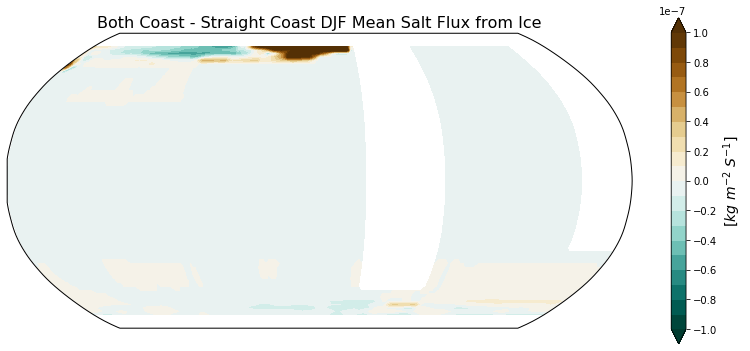

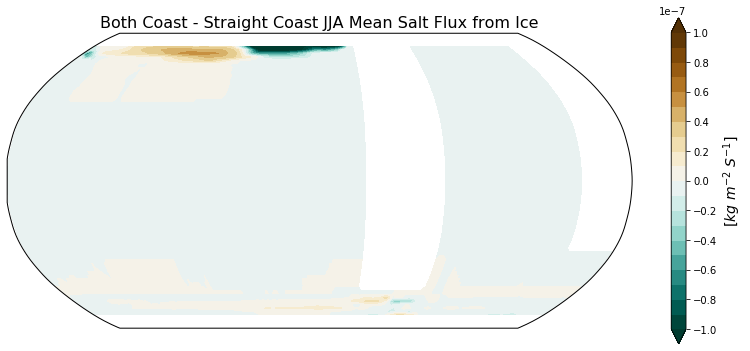

In [17]:
SALTF_straight = di_straight['SALTF'][-31:,:,:]
SALTF_djf_straight = np.nanmean(SALTF_straight.where(di_straight['time.season'] == 'DJF'), axis=0)
SALTF_jja_straight = np.nanmean(SALTF_straight.where(di_straight['time.season'] == 'JJA'), axis=0)
SALTF_both = di_both['SALTF'][-31:,:,:]
SALTF_djf_both = np.nanmean(SALTF_both.where(di_both['time.season'] == 'DJF'), axis=0)
SALTF_jja_both = np.nanmean(SALTF_both.where(di_both['time.season'] == 'JJA'), axis=0)

SALTF_djf = SALTF_djf_both - SALTF_djf_straight
SALTF_jja = SALTF_jja_both - SALTF_jja_straight

b = np.linspace(-1e-7, 1e-7, 21, endpoint=True)
t = np.linspace(-1e-7, 1e-7, 11, endpoint=True)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(di_straight['xT'], di_straight['yT'], SALTF_djf, b, cmap='BrBG_r',
             extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel(r'$[kg\ m^{-2}\ S^{-1}]$', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} DJF Mean Salt Flux from Ice'.format(case_both, case_straight), fontsize=16)
# plt.savefig(fig_path+'MLD_DJF.png')
plt.show()

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(di_straight['xT'], di_straight['yT'], SALTF_jja, b, cmap='BrBG_r',
             extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel(r'$[kg\ m^{-2}\ S^{-1}]$', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} JJA Mean Salt Flux from Ice'.format(case_both, case_straight), fontsize=16)
# plt.savefig(fig_path+'MLD_JJA.png')
plt.show()

In [24]:
dm_am

<xarray.Dataset>
Dimensions:     (nv: 2, time: 360, xh: 180, xq: 180, yh: 81, yq: 81, zi: 32, zl: 31)
Coordinates:
  * xh          (xh) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * yh          (yh) float64 -80.0 -78.0 -76.0 -74.0 ... 74.0 76.0 78.0 80.0
  * time        (time) object 2100-01-16 12:00:00 ... 2129-12-16 12:00:00
  * nv          (nv) float64 1.0 2.0
  * zl          (zl) float64 2.5 10.0 20.0 32.5 ... 3.5e+03 4e+03 4.625e+03
  * xq          (xq) float64 2.0 4.0 6.0 8.0 10.0 ... 354.0 356.0 358.0 360.0
  * zi          (zi) float64 0.0 5.0 15.0 25.0 ... 3.75e+03 4.25e+03 5e+03
  * yq          (yq) float64 -79.0 -77.0 -75.0 -73.0 ... 75.0 77.0 79.0 81.0
Data variables:
    pbo         (time, yh, xh) float32 ...
    pso         (time, yh, xh) float32 ...
    zos         (time, yh, xh) float32 ...
    zossq       (time, yh, xh) float32 ...
    thetao      (time, zl, yh, xh) float32 ...
    tos         (time, yh, xh) float32 ...
    tossq       (time, yh, xh) float